<img src="images/deep_ga.png" align=right width=50%></img>
# Deep Neuroevolution
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Configuration](#Configuration)
- [Genotype](#Genotype)
- [Phenotype](#Phenotype)
- [Environment](#Environment)
- [Genetic Algorithm (GA)](#Genetic-Algorithm-%28GA%29)

In [29]:
import random
from copy import deepcopy

import numpy as np
from matplotlib import pyplot as plt
import gym
from gym import ObservationWrapper
from gym.spaces.box import Box
from baselines.common import atari_wrappers
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as T
from torchsummary import summary
from deap import creator, base, tools
from IPython import display

In [35]:
%matplotlib inline

## Configuration

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)

DEVICE = cuda


In [31]:
SIGMA = 0.005
ENV_NAME = "PongNoFrameskip-v4"
ENV_SEED = 42
SCREEN_SIZE = 84
MAX_ITER = 500
N_GEN = 1000
POP_SIZE = 1000
N_SEL = 200

## Genotype

In [5]:
def rand_seed():
    return random.randint(0, 2**31-1)

In [6]:
def mutate(ind):
    ind.append(rand_seed())
    return ind,

In [7]:
def decode(genotype, tmpl_model, sigma):
    model = deepcopy(tmpl_model)
    for seed in genotype:
        # NOTE: in the paper, the first seed is used for initialization,
        # but in such case, every individual in the first generation is
        # initialized around zero; we probably don't want that.
        #
        # Instead, we're going to assume that all individuals are already
        # initialized with a better initialization method, e.g., Xavier.
        torch.manual_seed(seed)
        for param in model.parameters():
            param.data.add_(torch.randn_like(param) * sigma)
    return model

Ooh, looks like we're going to have to implement the phenotype before testing `deocde`.

## Phenotype

In [8]:
class NatureDQN(nn.Module):
    def __init__(self, in_channels=4, act_dim=18):
        super(NatureDQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, act_dim)
        
        def init_weights(m):
            if type(m) in {nn.Conv2d, nn.Linear}:
                torch.nn.init.xavier_uniform_(m.weight)
        self.apply(init_weights)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc4(x))
        return F.softmax(self.fc5(x), dim=-1)

Now, let's take a look at the network. Remember, `tmpl_model` below will be used to decode each individual genotype during evolution.

In [9]:
TMPL_MODEL = NatureDQN().to(DEVICE)
summary(TMPL_MODEL, (4, SCREEN_SIZE, SCREEN_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                   [-1, 18]           9,234
Total params: 1,693,362
Trainable params: 1,693,362
Non-trainable params: 0
----------------------------------------------------------------


## Environment

In [22]:
class TorchWrapper(ObservationWrapper):
    r"""ObservationWrapper that outputs observation with the shape of (channels, height, width).
    NOTE: adopted from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr.
    """
    def __init__(self, env=None):
        super(TorchWrapper, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(self.observation_space.low[0, 0, 0],
                                     self.observation_space.high[0, 0, 0],
                                     [obs_shape[2], obs_shape[1], obs_shape[0]],
                                     dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)

In [23]:
def render(env, t):
    display.clear_output(wait=True)
    plt.figure()
    plt.clf()
    plt.axis("off")
    plt.title(f"t = {t}")
    plt.imshow(env.render(mode='rgb_array'))
    plt.pause(0.001)

In [33]:
def make_atari(env_id):
    env = atari_wrappers.make_atari(env_id)
    env = atari_wrappers.wrap_deepmind(env)
    env = TorchWrapper(env)
    env.seed(ENV_SEED)
    return env

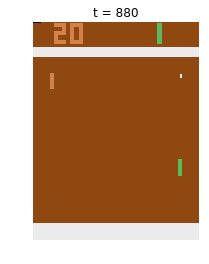

In [36]:
env = make_atari(ENV_NAME)
obs = env.reset()

t = done = 0
while not done:
    if t % 10 == 0:
        render(env, t)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    t += 1

In [22]:
def evaluate(ind):
    env = gym.make(ENV_NAME).unwrapped
    policy = decode(ind, TMPL_MODEL, SIGMA)
    policy.eval()
    
    obs = render(env)
    i = done = fitness = 0
    while not done and i < MAX_ITER:
        act_probs = policy(obs)
        action = torch.argmax(act_probs)
        _, reward, done, _ = env.step(action)
        obs = render(env)
        fitness += reward
        i += 1
    return fitness,

## Genetic Algorithm (GA)

In [13]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [23]:
toolbox = base.Toolbox()
toolbox.register("individual", tools.initRepeat, list, rand_seed, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mutate", mutate)
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selBest, k=N_SEL)